In [1]:
from generator import generate

In [2]:
generate(labels=[62])

c:\Users\Nathan\.conda\envs\torch\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


['0063e678-9899-4ea2-9660-820ca5a082bb.png']

In [ ]:
import os
import torch
import numpy as np

from PIL import Image
from sampler import KLMSSampler
from diffusion import Diffusion
from autoencoder import Decoder

In [ ]:
index = [10]
embeddings = np.load(os.path.join('checkpoints', 'embeddings.npy'))
embeddings = torch.from_numpy(embeddings[index])
embeddings = embeddings.float().cuda()

embeddings.shape # label embedding shape

torch.Size([1, 77, 768])

In [ ]:
sampler = KLMSSampler(n_inference_steps=50)
latents = torch.randn((len(index), 4, 64, 64))
latents *= sampler.initial_scale
latents = latents.float().cuda()

latents.shape  # latent noise shape

torch.Size([1, 4, 64, 64])

In [ ]:
diffusion = Diffusion().cuda()
diffusion.load_state_dict(torch.load(os.path.join('checkpoints', 'diffusion.pt')))

<All keys matched successfully>

In [ ]:
diffusion.eval()
with torch.autocast('cuda') and torch.inference_mode():
    for timestep in sampler.timesteps:
        input_latents = latents * sampler.get_input_scale()
        time_embedding = sampler.get_time_embedding(timestep).float().cuda()
        output = diffusion(input_latents, embeddings, time_embedding)
        
        latents = sampler.step(latents, output)
# free memory
diffusion.cpu()
del diffusion
torch.cuda.empty_cache()

latents.shape  # de-noised latent shape

torch.Size([1, 4, 64, 64])

In [ ]:
decoder = Decoder().cuda()
decoder.load_state_dict(torch.load(os.path.join('checkpoints', 'decoder.pt')))

<All keys matched successfully>

In [ ]:
decoder.eval()
with torch.autocast('cuda') and torch.inference_mode():
    images = decoder(latents)
    
# free memory
decoder.cpu()
del decoder
torch.cuda.empty_cache()

images.shape  # generated image shape

torch.Size([1, 3, 512, 512])

In [ ]:
images = images.detach().cpu()
images = ((255.0 * images) / 2) + 127.5
images = images.clamp(0, 255)
images = images.permute(0, 2, 3, 1)
images = images.numpy().astype(np.uint8)

images.shape

(1, 512, 512, 3)

In [ ]:
images = [Image.fromarray(image) for image in images]

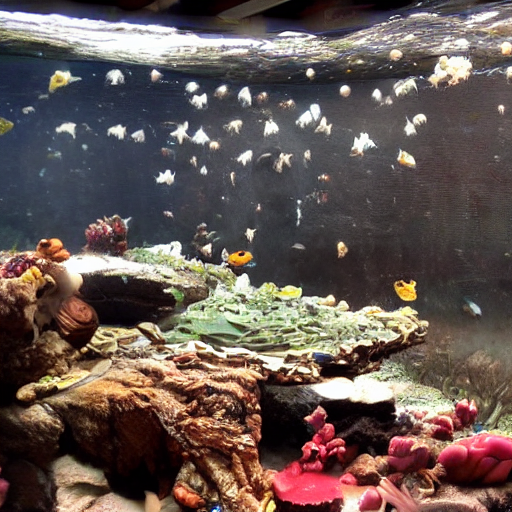

In [ ]:
images[0]